# Fine-Tuned CNN for Hand Gesture Recognition on HaGRID Dataset


In [6]:
# Fine-Tuning MobileNetV3 on HaGRID (with Experiment Tracking)

# 1. Imports & Parameters  
# 2. **Experiment Tracker Definition**  
# 3. Data Loading & Augmentation  
# 4. Build Model  
# 5. Callbacks  
# 6. Stage 1 Training (Head Only)  
# 7. **Log Stage 1 Results**  
# 8. Stage 2 Fine-Tune (last 20 layers)  
# 9. **Log Stage 2 Results**  
# 10. Stage 3 Fine-Tune (last 40 layers)  
# 11. **Log Stage 3 Results**  
# 12. Plot Curves & Confusion Matrix  
# 13. Save Final Model  
# 14. Display Experiment Log  


Found 110764 files belonging to 19 classes.
Found 28433 files belonging to 19 classes.
Classes: ['call', 'dislike', 'fist', 'four', 'like', 'mute', 'nothing', 'ok', 'one', 'palm', 'peace', 'peace_inverted', 'rock', 'stop', 'stop_inverted', 'three', 'three2', 'two_up', 'two_up_inverted']
Train batches: 3462
Val   batches: 889


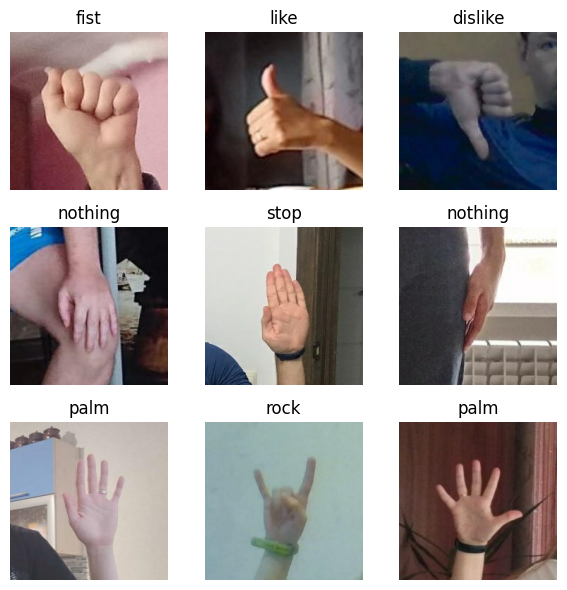

In [24]:
#to visualize the croped dataset
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt

# 1) Load the *raw* cropped directories (no .map/.cache yet)
raw_train = image_dataset_from_directory(
    r"C:\Users\AliRAMADAN\Desktop\hagrid_crops\train",
    image_size=(224,224),
    batch_size=32,
    shuffle=True
)
raw_val = image_dataset_from_directory(
    r"C:\Users\AliRAMADAN\Desktop\hagrid_crops\val",
    image_size=(224,224),
    batch_size=32,
    shuffle=False
)

# 2) Sanity-check folder contents & classes
print("Classes:", raw_train.class_names)
print("Train batches:", tf.data.experimental.cardinality(raw_train).numpy())
print("Val   batches:", tf.data.experimental.cardinality(raw_val).numpy())

# 3) Visualize a handful of crops
plt.figure(figsize=(6,6))
for images, labels in raw_train.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        img = images[i].numpy().astype("uint8")
        lbl = raw_train.class_names[int(labels[i].numpy())]
        plt.imshow(img)
        plt.title(lbl)
        plt.axis("off")
plt.tight_layout()
plt.show()


In [25]:
# Cell 1: Imports & parameters
import time, os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# Params
batch_size = 32
img_size = (224, 224)
train_dir = r"C:\Users\AliRAMADAN\Desktop\hagrid_crops\train"
val_dir   = r"C:\Users\AliRAMADAN\Desktop\hagrid_crops\val"
num_classes = len(os.listdir(train_dir))


In [26]:
# Cell 2: Experiment Tracker Definition
experiment_log = pd.DataFrame(columns=[
    "Stage", "Layers_Unfrozen", "Learning_Rate", "Mixed_Precision",
    "Val_Accuracy", "Latency_per_Image_s", "Model_Size_MB"
])

def log_experiment(stage, layers_unfrozen, lr, mixed_precision, model, history, val_ds, model_path):
    val_acc = history.history["val_accuracy"][-1]
    # sample one batch
    sample_images, _ = next(iter(val_ds.take(1)))
    start = time.time()
    _ = model.predict(sample_images, verbose=0)
    latency = (time.time() - start) / len(sample_images)
    size_mb = os.path.getsize(model_path) / (1024 * 1024)
    experiment_log.loc[len(experiment_log)] = {
        "Stage": stage,
        "Layers_Unfrozen": layers_unfrozen,
        "Learning_Rate": lr,
        "Mixed_Precision": mixed_precision,
        "Val_Accuracy": round(val_acc,4),
        "Latency_per_Image_s": round(latency,4),
        "Model_Size_MB": round(size_mb,2)
    }


In [27]:
# Cell 3: Data loading + augmentation
train_ds = image_dataset_from_directory(train_dir, image_size=img_size, batch_size=batch_size, shuffle=True)
val_ds   = image_dataset_from_directory(val_dir,   image_size=img_size, batch_size=batch_size)
aug = tf.keras.Sequential([tf.keras.layers.RandomFlip("horizontal"),
                           tf.keras.layers.RandomRotation(0.1),
                           tf.keras.layers.RandomZoom(0.1)])
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.map(lambda x,y: (aug(x), y), num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)


Found 110764 files belonging to 19 classes.
Found 28433 files belonging to 19 classes.


In [10]:
# print("Class names (in index order):")
# for idx, name in enumerate(train_ds.class_names):
#     print(f"{idx}: {name}")

In [11]:
# Cell 4: Build & compile model
base_model = MobileNetV3Small(input_shape=img_size+(3,), include_top=False, weights="imagenet")
base_model.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.3),
    Dense(128, activation="relu"),
    Dropout(0.2),
    Dense(num_classes, activation="softmax")
])
model.compile(optimizer=Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])


In [12]:
# Cell 5: Callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2),
    ModelCheckpoint("stage1_best.keras", save_best_only=True)
]


In [13]:
# Cell 6: Stage 1 - Train head only
history1 = model.fit(train_ds, validation_data=val_ds, epochs=5, callbacks=callbacks)


Epoch 1/5
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 1194s 344ms/step - accuracy: 0.4309 - loss: 1.8178 - val_accuracy: 0.7155 - val_loss: 0.9084 - learning_rate: 0.0010
Epoch 2/5
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 934s 269ms/step - accuracy: 0.5451 - loss: 1.4112 - val_accuracy: 0.7162 - val_loss: 0.8845 - learning_rate: 0.0010
Epoch 3/5
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 805s 232ms/step - accuracy: 0.5584 - loss: 1.3673 - val_accuracy: 0.7250 - val_loss: 0.8376 - learning_rate: 0.0010
Epoch 4/5
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 805s 232ms/step - accuracy: 0.5651 - loss: 1.3487 - val_accuracy: 0.7385 - val_loss: 0.8309 - learning_rate: 0.0010
Epoch 5/5
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 802s 231ms/step - accuracy: 0.5678 - loss: 1.3358 - val_accuracy: 0.7419 - val_loss: 0.8122 - learning_rate: 0.0010


In [14]:
# Cell 7: Log Stage 1
log_experiment(
    stage="Stage 1",
    layers_unfrozen=0,
    lr=1e-3,
    mixed_precision=False,
    model=model, history=history1,
    val_ds=val_ds, model_path="stage1_best.keras"
)


In [15]:
# Cell 8: Stage 2 - Unfreeze last 20 layers & fine-tune
for layer in base_model.layers[:-20]: layer.trainable=False
for layer in base_model.layers[-20:]: layer.trainable=True
model.compile(optimizer=Adam(1e-5), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
callbacks[2] = ModelCheckpoint("stage2_best.keras", save_best_only=True)
history2 = model.fit(train_ds, validation_data=val_ds, epochs=15, initial_epoch=5, callbacks=callbacks)


Epoch 6/15
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 923s 265ms/step - accuracy: 0.5610 - loss: 1.3700 - val_accuracy: 0.8141 - val_loss: 0.6093 - learning_rate: 1.0000e-05
Epoch 7/15
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 920s 265ms/step - accuracy: 0.6610 - loss: 1.0143 - val_accuracy: 0.8465 - val_loss: 0.5006 - learning_rate: 1.0000e-05
Epoch 8/15
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 920s 266ms/step - accuracy: 0.7139 - loss: 0.8561 - val_accuracy: 0.8671 - val_loss: 0.4364 - learning_rate: 1.0000e-05
Epoch 9/15
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 920s 266ms/step - accuracy: 0.7462 - loss: 0.7572 - val_accuracy: 0.8808 - val_loss: 0.3916 - learning_rate: 1.0000e-05
Epoch 10/15
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 935s 270ms/step - accuracy: 0.7692 - loss: 0.6925 - val_accuracy: 0.8907 - val_loss: 0.3607 - learning_rate: 1.0000e-05
Epoch 11/15
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 927s 268ms/step - accuracy: 0.7863 - loss: 0.6344 - val_accuracy: 0.8991 - val_loss: 0.3328 - learning_rate: 1.0000e-05
Epoch 12/15
3462/3462 ━━━━

In [16]:
# Cell 9: Log Stage 2
log_experiment(
    stage="Stage 2",
    layers_unfrozen=20,
    lr=1e-5,
    mixed_precision=False,
    model=model, history=history2,
    val_ds=val_ds, model_path="stage2_best.keras"
)


In [17]:
# Cell 10: Stage 3 - Unfreeze last 40 layers & fine-tune
for layer in base_model.layers[:-40]: layer.trainable=False
for layer in base_model.layers[-40:]: layer.trainable=True
model.compile(optimizer=Adam(1e-6), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
callbacks[2] = ModelCheckpoint("stage3_best.keras", save_best_only=True)
history3 = model.fit(train_ds, validation_data=val_ds, epochs=23, initial_epoch=15, callbacks=callbacks)


Epoch 16/23
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 1033s 296ms/step - accuracy: 0.8317 - loss: 0.5038 - val_accuracy: 0.9187 - val_loss: 0.2688 - learning_rate: 1.0000e-06
Epoch 17/23
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 1016s 293ms/step - accuracy: 0.8413 - loss: 0.4769 - val_accuracy: 0.9206 - val_loss: 0.2610 - learning_rate: 1.0000e-06
Epoch 18/23
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 1023s 295ms/step - accuracy: 0.8477 - loss: 0.4629 - val_accuracy: 0.9238 - val_loss: 0.2532 - learning_rate: 1.0000e-06
Epoch 19/23
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 1020s 295ms/step - accuracy: 0.8520 - loss: 0.4465 - val_accuracy: 0.9258 - val_loss: 0.2467 - learning_rate: 1.0000e-06
Epoch 20/23
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 1026s 296ms/step - accuracy: 0.8537 - loss: 0.4408 - val_accuracy: 0.9279 - val_loss: 0.2403 - learning_rate: 1.0000e-06
Epoch 21/23
3462/3462 ━━━━━━━━━━━━━━━━━━━━ 1033s 298ms/step - accuracy: 0.8562 - loss: 0.4311 - val_accuracy: 0.9293 - val_loss: 0.2356 - learning_rate: 1.0000e-06
Epoch 22/23
3462

In [18]:
# Cell 11: Log Stage 3
log_experiment(
    stage="Stage 3",
    layers_unfrozen=40,
    lr=1e-6,
    mixed_precision=False,
    model=model, history=history3,
    val_ds=val_ds, model_path="stage3_best.keras"
)


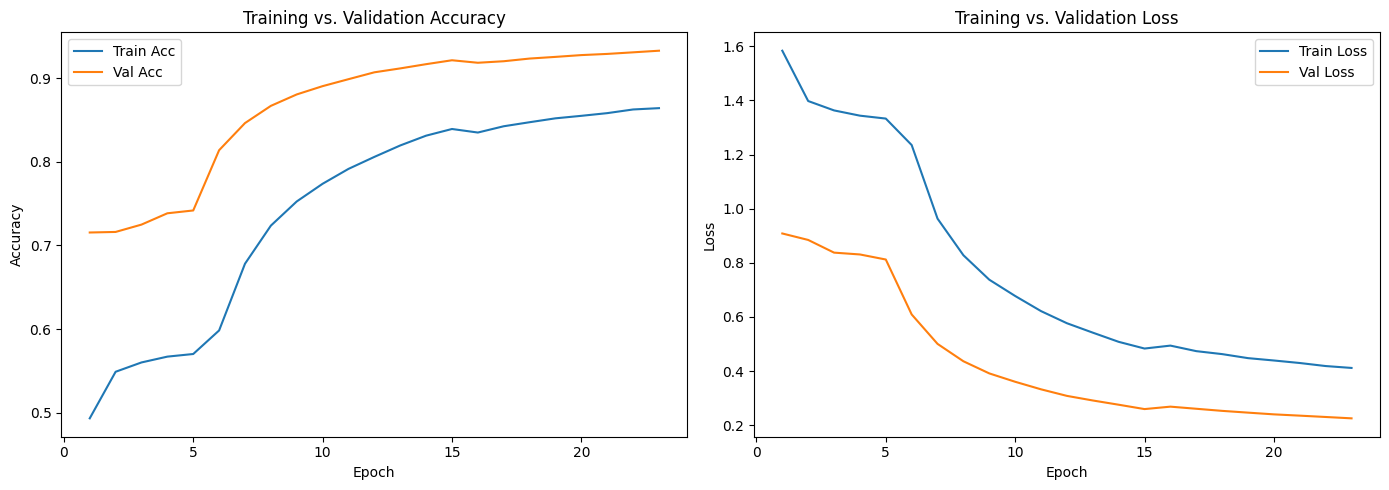

Classification Report:

                 precision    recall  f1-score   support

           call       0.91      0.93      0.92       991
        dislike       0.98      0.98      0.98       978
           fist       0.98      0.99      0.99       944
           four       0.84      0.85      0.84      1046
           like       0.94      0.93      0.94      1769
           mute       0.99      0.98      0.99      1786
        nothing       0.99      0.98      0.98      6595
             ok       0.92      0.91      0.92      1001
            one       0.91      0.89      0.90      1012
           palm       0.94      0.96      0.95      1894
          peace       0.83      0.79      0.81       957
 peace_inverted       0.86      0.94      0.90       910
           rock       0.94      0.91      0.92      1802
           stop       0.97      0.91      0.94      1826
  stop_inverted       0.89      0.95      0.92       995
          three       0.82      0.75      0.78       982
      

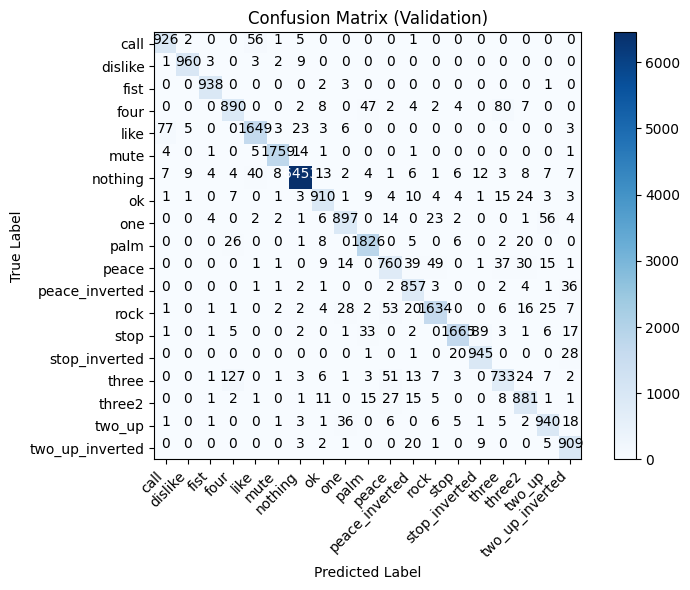

In [19]:
# Cell 12: Plot curves & confusion matrix (fixed)

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

# 0) Re-derive class names from your train directory
class_names = sorted(os.listdir(train_dir))

# 1) Aggregate histories from all stages
acc     = history1.history["accuracy"]  + history2.history["accuracy"]  + history3.history["accuracy"]
val_acc = history1.history["val_accuracy"]+ history2.history["val_accuracy"]+ history3.history["val_accuracy"]
loss    = history1.history["loss"]      + history2.history["loss"]      + history3.history["loss"]
val_loss= history1.history["val_loss"]  + history2.history["val_loss"]  + history3.history["val_loss"]

# 2) Plot accuracy and loss
epochs = range(1, len(acc) + 1)
plt.figure(figsize=(14,5))

plt.subplot(1,2,1)
plt.plot(epochs, acc,     label="Train Acc")
plt.plot(epochs, val_acc, label="Val Acc")
plt.xlabel("Epoch"); plt.ylabel("Accuracy")
plt.title("Training vs. Validation Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(epochs, loss,     label="Train Loss")
plt.plot(epochs, val_loss, label="Val Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Training vs. Validation Loss")
plt.legend()

plt.tight_layout()
plt.show()


# 3) Confusion Matrix & Classification Report on validation set
y_true, y_pred = [], []

for imgs, labels in val_ds:
    preds = model.predict(imgs, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix (Validation)")
plt.colorbar()

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha="right")
plt.yticks(tick_marks, class_names)

# Annotate each cell
thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, f"{cm[i, j]}", 
             ha="center", 
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()


In [20]:
# Cell 13: Save final model
model.save("mobilenetv3_hagrid_finetuned.keras")


In [21]:
# Cell 14: Display experiment log without ace_tools

import pandas as pd
from IPython.display import display  # Jupyter’s own display helper

# If you want a plain text table
print(experiment_log)

# Or, for a nicely formatted table in Jupyter:
display(experiment_log)


     Stage  Layers_Unfrozen  Learning_Rate  Mixed_Precision  Val_Accuracy  \
0  Stage 1                0       0.001000            False        0.7419   
1  Stage 2               20       0.000010            False        0.9217   
2  Stage 3               40       0.000001            False        0.9331   

   Latency_per_Image_s  Model_Size_MB  
0               0.0347           5.00  
1               0.0488           7.69  
2               0.0376          10.48  


,Stage,Layers_Unfrozen,Learning_Rate,Mixed_Precision,Val_Accuracy,Latency_per_Image_s,Model_Size_MB
0,Stage 1,0,0.001000,False,0.7419,0.0347,5.00
1,Stage 2,20,0.000010,False,0.9217,0.0488,7.69
2,Stage 3,40,0.000001,False,0.9331,0.0376,10.48
